# Task C: NLP Cousework

## Importations

In [1]:
# built-in
import re
import codecs
import random
from collections import defaultdict
import sys
import os

# common libs
import pandas as pd
import numpy as np 
from tqdm import tqdm

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

# nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, Embedding, LSTM, GRU, Bidirectional
from keras.models import Model
from keras import optimizers, initializers
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.engine.topology import Layer, InputSpec

# torch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#sklearn
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


#bayes_opt
from bayes_opt import BayesianOptimization


# import EarlyStopping
from pytorchtools import EarlyStopping

C:\Users\Thomas\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sns.set_style(style='dark')
%matplotlib inline

## Getting the data ready

### Loading

In [3]:
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [4]:
data = pd.read_csv("training-v1/offenseval-training-v1.tsv", delimiter='\t', engine='c')
data_aside = pd.read_csv("Test_C_Release/test_set_taskc.tsv", delimiter='\t', engine='c')
data = data[data.subtask_a == 'OFF']
data = data[data.subtask_b == 'TIN']

In [5]:
df = data.copy()
df_aside = data_aside.copy()
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['subtask_c'])))

Shape of dataset  (3876, 5)
Index(['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c'], dtype='object')
No. of unique classes 3


### Labels to integers

In [6]:
classes=sorted(set(df['subtask_c']))
classes_to_id = {'GRP': [1,0,0], 'IND': [0,1,0], 'OTH': [0,0,1]}

def fun(i):
    return classes_to_id[i]

df['subtask_c']=df['subtask_c'].apply(fun)

### Cleaning the data

In [7]:
aside = np.array(df_aside.tweet)
aside_length = len(aside)
tweets = np.concatenate([np.array(df.tweet), aside], axis =0)

regexp1 = r'@[A-Za-z0-9]+'
regexp2 = r'https?://[A-Za-z0-9./]+'

combined_regexp = r'|'.join((regexp1, regexp2)) #getting rid of @USER and potentiel URLs

def low_stemmed_token_sentence(string, regexp = combined_regexp, SW = False):
# this tokenizer just accepts alphabetic word (remove numeric)
        
    cleaned = re.sub(regexp, '', string)
    tokenizer = RegexpTokenizer('[a-z]+') #splits the string into substrings we strip the # 
    stemmer = PorterStemmer() #basically it is suffix stripping
    
    low = cleaned.lower().replace('url', '')
    tokens = tokenizer.tokenize(low)
    if SW == True:
        stopWords = set(stopwords.words('english')) #creates a set of words that will be ignored
        filtered_tokens = []
        for tok in tokens:
            if tok not in stopWords:
                filtered_tokens.append(tok)
        tokens = filtered_tokens
        
    stemmed_tokens = [stemmer.stem(i) for i in tokens]
    return ((stemmed_tokens))
print(f"data set size : {data.shape}, test set size : {data_aside.shape}")

data set size : (3876, 5), test set size : (213, 2)


In [8]:
clean_tweets = [low_stemmed_token_sentence(x, SW=False) for x in tweets]
print(len(clean_tweets))
clean_tweets[:2]

4089


[['go', 'home', 'you', 're', 'drunk', 'maga', 'trump'],
 ['liber', 'are', 'all', 'kookoo']]

### Word tokens to integrer tokens

In [9]:
sent_lengths = [len(sent) for sent in clean_tweets]
max_len = np.max(np.array(sent_lengths))
MAX_SEQUENCE_LENGTH = max_len

In [10]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(clean_tweets)
sequences = tokenizer.texts_to_sequences(clean_tweets)
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 7453


In [11]:
sequences[:1]

array([[ 52, 355,   6,  89, 754,  54,  55,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

### Back to dataframes

In [12]:
data.head(2)

,id,tweet,subtask_a,subtask_b,subtask_c
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH


In [13]:
labels = np.array(df['subtask_c'])
data['tweet'] = list(sequences[:-aside_length])
data_aside['tweet'] = list(sequences[-aside_length:])
data['subtask_c'] = labels
data.head(2)

,id,tweet,subtask_a,subtask_b,subtask_c
1,90194,"[52, 355, 6, 89, 754, 54, 55, 0, 0, 0, 0, 0, 0...",OFF,TIN,"[0, 1, 0]"
5,97670,"[19, 8, 27, 3682, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",OFF,TIN,"[0, 0, 1]"


### Train, Validation & Test sets

In [14]:
nb_l = data.shape[1]

train, validation, test = data[0:3000], \
        data[3000:3500], data[3500:]
    
    
x_train = np.array(list(train.tweet))
y_train = np.array(list(train.subtask_c))
x_val = np.array(list(validation.tweet))
y_val = np.array(list(validation.subtask_c))
x_test = np.array(list(test.tweet))
y_test = np.array(list(test.subtask_c))

x_aside = np.array(list(data_aside.tweet))

### Importation of Glove

In [15]:
embeddings_index = {}
f = open('./glove/glove.6B/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [16]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [18]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(25, activation = 'relu'))(embedded_sequences)
preds = Dense(len(classes), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
optim = optimizers.Adam(lr = 0.0010, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.003) #lr = 0.0001, wd = 0.001
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 63, 100)           745400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50)                25200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 770,753
Trainable params: 770,753
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val)\
                  ,epochs=25, batch_size=2,callbacks=[cp], verbose=2)

Train on 3000 samples, validate on 500 samples
Epoch 1/25
 - 100s - loss: 0.8244 - acc: 0.6447 - val_loss: 0.8259 - val_acc: 0.6340

Epoch 00001: val_acc improved from -inf to 0.63400, saving model to model_rnn.hdf5
Epoch 2/25
 - 102s - loss: 0.7104 - acc: 0.7123 - val_loss: 0.8066 - val_acc: 0.6540

Epoch 00002: val_acc improved from 0.63400 to 0.65400, saving model to model_rnn.hdf5
Epoch 3/25
 - 98s - loss: 0.6702 - acc: 0.7300 - val_loss: 0.8028 - val_acc: 0.6580

Epoch 00003: val_acc improved from 0.65400 to 0.65800, saving model to model_rnn.hdf5
Epoch 4/25
 - 96s - loss: 0.6407 - acc: 0.7417 - val_loss: 0.8199 - val_acc: 0.6540

Epoch 00004: val_acc did not improve
Epoch 5/25
 - 96s - loss: 0.6206 - acc: 0.7447 - val_loss: 0.8086 - val_acc: 0.6700

Epoch 00005: val_acc improved from 0.65800 to 0.67000, saving model to model_rnn.hdf5
Epoch 6/25
 - 87s - loss: 0.6069 - acc: 0.7553 - val_loss: 0.8090 - val_acc: 0.6680

Epoch 00006: val_acc did not improve
Epoch 7/25
 - 97s - loss: 

## On test set

In [65]:
id_to_classes = { 0: 'GRP', 1: 'IND',2: 'OTH'}

predictions = np.argmax(model.predict(x_aside), axis =1)
p = [id_to_classes[x] for x in predictions]

In [68]:
data_aside.tweet = p
data_aside.head(5)

,id,tweet
0,15923,GRP
1,60133,GRP
2,83681,IND
3,65507,IND
4,34263,IND


In [73]:
data_aside.index = data_aside.id
data_aside.drop(columns=['id'], inplace = True)
data_aside.to_csv('test_1_c.csv',sep=',', header = False)
data_aside[:5]

,tweet
id,
15923,GRP
60133,GRP
83681,IND
65507,IND
34263,IND


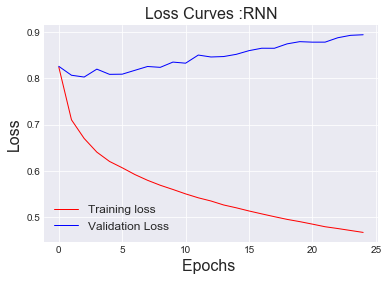

In [20]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=1.0)
plt.plot(history.history['val_loss'],'b',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.grid()
plt.show()

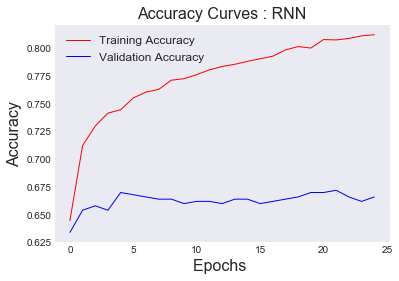

In [21]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=1.0)
plt.plot(history.history['val_acc'],'b',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

In [22]:
from keras.utils.vis_utils import plot_model

In [23]:
plot_model(model, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)

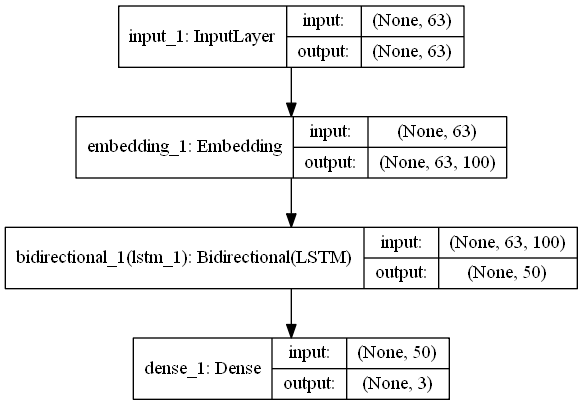

In [24]:
from PIL import Image
display(Image.open('rnn_model.png'))